# Handwritten Digit Recognition. 

## Problem Statement
A classic problem in the field of pattern recognition is that of handwritten digit recognition. Suppose that you have images of handwritten digits ranging from 0-9 written by various people in boxes of a specific size - similar to the application forms in banks and universities.

 

The goal is to develop a model that can correctly identify the digit (between 0-9) written in an image. 

 

Objective
You are required to develop a model using Support Vector Machine which should correctly classify the handwritten digits from 0-9 based on the pixel values given as features. Thus, this is a 10-class classification problem. 

 

Data Description
For this problem, we use the MNIST data which is a large database of handwritten digits. The 'pixel values' of each digit (image) comprise the features, and the actual number between 0-9 is the label. 

 

Since each image is of 28 x 28 pixels, and each pixel forms a feature, there are 784 features. MNIST digit recognition is a well-studied problem in the ML community, and people have trained numerous models (Neural Networks, SVMs, boosted trees etc.) achieving error rates as low as 0.23% (i.e. accuracy = 99.77%, with a convolutional neural network).

 

Before the popularity of neural networks, though, models such as SVMs and boosted trees were the state-of-the-art in such problems.

 

This webpage (from the original contributors of the dataset) tabulates the accuracies achieved by various classification models. http://yann.lecun.com/exdb/mnist/

In this assignment, try experimenting with various hyperparameters in SVMs and observe the highest accuracy you can get. With a sub-sample of 10-20% of the training data (see note below), you should expect to get an accuracy of more than 90%.

 

Important Note:

Since the training dataset is quite large (42,000 labelled images), it would take a lot of time for training an SVM on the full MNIST data, so you can sub-sample the data for training (10-20% of the data should be enough to achieve decent accuracy). Also, running a GridSearchCV() may take hours if you use a large value of k (fold-CV) such as 10 and a wide range of hyperparameters; k = 5 should be sufficient.

Downloads
You can download the dataset from Kaggle here - please use train.csv to train the model and test.csv to evaluate the results. https://www.kaggle.com/c/digit-recognizer/data

 

Bonus - You may want to participate in this Kaggle competition and see your rank on the leaderboard. 
http://www.kaggle.com/c/digit-recognizer/data
 

Since this is a non-graded assignment, you can evaluate your solution yourself using the rubrics provided on the next page.

In [1]:
# libraries
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale

# dataset
numbers = pd.read_csv("ministdataset/train.csv")

In [2]:
# about the dataset

# dimensions
print("Dimensions: ", numbers.shape, "\n")

# data types
print(numbers.info())

# head
numbers.head()

Dimensions:  (42000, 785) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB
None


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
print(numbers.columns)

Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785)


In [4]:
order = list(np.sort(numbers['label'].unique()))
print(order)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [5]:
numbers_means = numbers.groupby('label').mean()
numbers_means.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
label,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


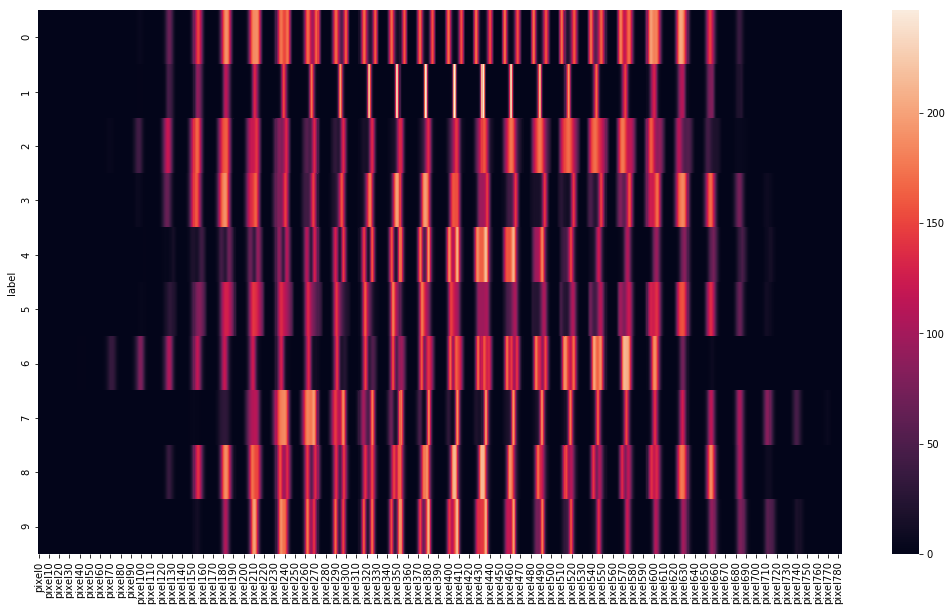

In [6]:
plt.figure(figsize=(18, 10))
sns.heatmap(numbers_means)

In [7]:
# average feature values
round(numbers.drop('label', axis=1).mean(), 2)

pixel0      0.00
pixel1      0.00
pixel2      0.00
pixel3      0.00
pixel4      0.00
pixel5      0.00
pixel6      0.00
pixel7      0.00
pixel8      0.00
pixel9      0.00
pixel10     0.00
pixel11     0.00
pixel12     0.00
pixel13     0.01
pixel14     0.01
pixel15     0.00
pixel16     0.00
pixel17     0.00
pixel18     0.00
pixel19     0.00
pixel20     0.00
pixel21     0.00
pixel22     0.00
pixel23     0.00
pixel24     0.00
pixel25     0.00
pixel26     0.00
pixel27     0.00
pixel28     0.00
pixel29     0.00
            ... 
pixel754    0.00
pixel755    0.00
pixel756    0.00
pixel757    0.00
pixel758    0.00
pixel759    0.00
pixel760    0.00
pixel761    0.01
pixel762    0.04
pixel763    0.08
pixel764    0.11
pixel765    0.18
pixel766    0.30
pixel767    0.41
pixel768    0.51
pixel769    0.56
pixel770    0.68
pixel771    0.60
pixel772    0.49
pixel773    0.34
pixel774    0.22
pixel775    0.12
pixel776    0.06
pixel777    0.02
pixel778    0.02
pixel779    0.00
pixel780    0.00
pixel781    0.

In [8]:
# splitting into X and y
X = numbers.drop("label", axis = 1)
y = numbers['label']

In [9]:
# scaling the features
X_scaled = scale(X)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size=0.50, random_state = 101)

C:\Users\lenovo\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [10]:
# linear model

model_linear = SVC(kernel='linear')
model_linear.fit(X_train, y_train)

# predict
y_pred = model_linear.predict(X_test)


In [11]:
# confusion matrix and accuracy

# accuracy
print("accuracy:", metrics.accuracy_score(y_true=y_test, y_pred=y_pred), "\n")

# cm
print(metrics.confusion_matrix(y_true=y_test, y_pred=y_pred))

accuracy: 0.9177142857142857 

[[1986    0    3    3    6   15   15    2    6    2]
 [   0 2302   10    6    5    1    1    1   18    1]
 [  22   21 1908   30   23    9   16   21   32   10]
 [   7   13   76 1899    4   83    3    5   50   14]
 [  10    6   19    3 1923    4    9   17    3   58]
 [  17    7   13  109   21 1634   25    4   48    8]
 [  14    3   27    1   15   25 1969    0    7    0]
 [   4   13   20   27   32    5    0 2017    2   68]
 [  10   28   52   81    7   86   10   14 1759   12]
 [  17    8    6   23   99    8    0   73   16 1875]]


In [12]:
# non-linear model
# using rbf kernel, C=1, default value of gamma

# model
non_linear_model = SVC(kernel='rbf')

# fit
non_linear_model.fit(X_train, y_train)

# predict
y_pred = non_linear_model.predict(X_test)

In [13]:
# confusion matrix and accuracy

# accuracy
print("accuracy:", metrics.accuracy_score(y_true=y_test, y_pred=y_pred), "\n")

# cm
print(metrics.confusion_matrix(y_true=y_test, y_pred=y_pred))

accuracy: 0.9566666666666667 

[[2002    0    5    1    2    7    9    2   10    0]
 [   0 2308   12    6    5    2    1    3    7    1]
 [   8    4 1995   13   14    3    8   24   20    3]
 [   2    6   34 2026    3   20    2   21   29   11]
 [   2    2   21    1 1974    4    8    9    2   29]
 [   5    2   10   33    4 1785   16   14   15    2]
 [  11    4    8    1    6   21 1988   18    4    0]
 [   1    6   10    9   17    0    1 2105    0   39]
 [   5   10   14   27   11   26    7   11 1940    8]
 [   9    4   11   18   44    1    0   58   13 1967]]


In [14]:
# creating a KFold object with 5 splits 
folds = KFold(n_splits = 5, shuffle = True, random_state = 101)

# specify range of hyperparameters
# Set the parameters by cross-validation
hyper_params = [ {'gamma': [1e-2, 1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]}]


# specify model
model = SVC(kernel="rbf")

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = model, 
                        param_grid = hyper_params, 
                        scoring= 'accuracy', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 392.0min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=101, shuffle=True),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'gamma': [0.01, 0.001, 0.0001], 'C': [1, 10, 100, 1000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=1)

In [15]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,476.152195,0.779270,57.621917,0.095341,1,0.01,"{'C': 1, 'gamma': 0.01}",0.793571,0.799762,0.800238,...,0.796095,0.004139,12,0.999881,0.999583,0.999643,0.999702,0.999524,0.999667,0.000123
1,87.999295,0.526445,28.582551,0.137272,1,0.001,"{'C': 1, 'gamma': 0.001}",0.939762,0.952381,0.949048,...,0.944429,0.005255,4,0.974643,0.973512,0.975417,0.975298,0.974464,0.974667,0.000683
2,124.158238,0.272939,39.784636,0.181560,1,0.0001,"{'C': 1, 'gamma': 0.0001}",0.916667,0.922619,0.924524,...,0.916857,0.006086,8,0.928036,0.926250,0.925893,0.928631,0.927500,0.927262,0.001042
3,486.358893,1.265588,57.813904,0.160388,10,0.01,"{'C': 10, 'gamma': 0.01}",0.807143,0.814048,0.814048,...,0.809619,0.003820,9,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
4,74.754843,0.520738,25.430099,0.175776,10,0.001,"{'C': 10, 'gamma': 0.001}",0.954048,0.960476,0.955714,...,0.953905,0.004314,1,0.998274,0.998810,0.998512,0.998929,0.998333,0.998571,0.000258
5,58.393739,0.330525,24.079731,0.147434,10,0.0001,"{'C': 10, 'gamma': 0.0001}",0.929762,0.937857,0.942143,...,0.934667,0.004756,6,0.959167,0.957738,0.957619,0.959345,0.958571,0.958488,0.000710
6,486.009312,1.382621,57.792916,0.033145,100,0.01,"{'C': 100, 'gamma': 0.01}",0.807143,0.814048,0.814048,...,0.809619,0.003820,9,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
7,74.339102,0.538769,25.454283,0.201418,100,0.001,"{'C': 100, 'gamma': 0.001}",0.954286,0.960000,0.953810,...,0.953000,0.004699,2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
8,43.826542,0.321803,19.269102,0.176945,100,0.0001,"{'C': 100, 'gamma': 0.0001}",0.933571,0.943810,0.944524,...,0.937810,0.005230,5,0.989464,0.988512,0.989583,0.989881,0.989107,0.989310,0.000470
9,485.808035,1.533150,57.701773,0.171433,1000,0.01,"{'C': 1000, 'gamma': 0.01}",0.807143,0.814048,0.814048,...,0.809619,0.003820,9,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000


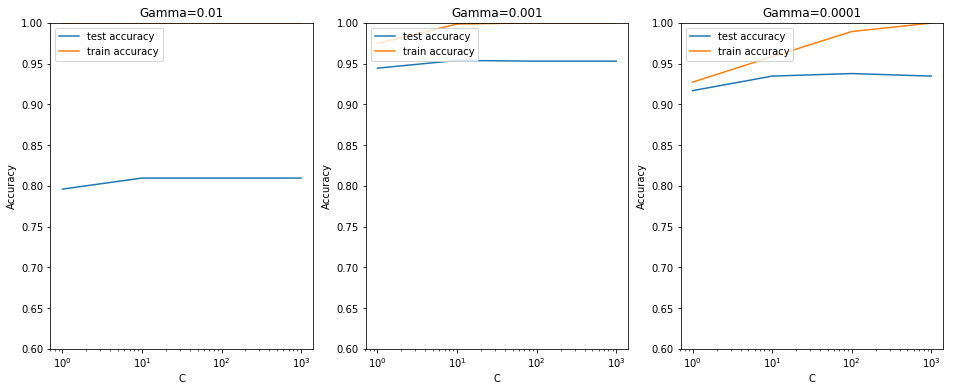

In [16]:
# converting C to numeric type for plotting on x-axis
cv_results['param_C'] = cv_results['param_C'].astype('int')

# # plotting
plt.figure(figsize=(16,6))

# subplot 1/3
plt.subplot(131)
gamma_01 = cv_results[cv_results['param_gamma']==0.01]

plt.plot(gamma_01["param_C"], gamma_01["mean_test_score"])
plt.plot(gamma_01["param_C"], gamma_01["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.01")
plt.ylim([0.60, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

# subplot 2/3
plt.subplot(132)
gamma_001 = cv_results[cv_results['param_gamma']==0.001]

plt.plot(gamma_001["param_C"], gamma_001["mean_test_score"])
plt.plot(gamma_001["param_C"], gamma_001["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.001")
plt.ylim([0.60, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')


# subplot 3/3
plt.subplot(133)
gamma_0001 = cv_results[cv_results['param_gamma']==0.0001]

plt.plot(gamma_0001["param_C"], gamma_0001["mean_test_score"])
plt.plot(gamma_0001["param_C"], gamma_0001["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.0001")
plt.ylim([0.60, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

In [17]:
# printing the optimal accuracy score and hyperparameters
best_score = model_cv.best_score_
best_hyperparams = model_cv.best_params_

print("The best test score is {0} corresponding to hyperparameters {1}".format(best_score, best_hyperparams))

The best test score is 0.9539047619047619 corresponding to hyperparameters {'C': 10, 'gamma': 0.001}


In [18]:
# model with optimal hyperparameters

# model
model = SVC(C=10, gamma=0.001, kernel="rbf")

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# metrics
print("accuracy", metrics.accuracy_score(y_test, y_pred), "\n")
print(metrics.confusion_matrix(y_test, y_pred), "\n")

accuracy 0.9645714285714285 

[[2006    0    4    0    1    6   11    2    7    1]
 [   0 2311   13    4    4    1    0    6    5    1]
 [   6    3 2017   10    9    3    6   24   10    4]
 [   2    2   28 2056    1   23    0   18   15    9]
 [   3    2   15    1 1979    3   11    8    1   29]
 [   8    0    5   28    4 1804   15    9   10    3]
 [   5    2    7    1    5   11 2009   16    5    0]
 [   2    9   12    5   21    1    1 2114    1   22]
 [   5    7   12   26   10   20    5   11 1954    9]
 [   5    4    6    9   40    4    0   42    9 2006]] 



In [19]:
numberstest = pd.read_csv("ministdataset/test.csv")
numberstest.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
numberstest_scaled = scale(numberstest)

In [21]:
numberstest_scaled

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [22]:
y_pred = model.predict(numberstest_scaled)

In [25]:
numberstest['id'] = numberstest.index+1
# Write the columns id, predictions into the output file
# Code is already written
d = pd.DataFrame({'ImageId': numberstest['id'], 'Label': y_pred})
d.to_csv('ministdataset/ministdataset_predictions.csv', sep=",",  index = False)

In [26]:
d

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,4
4,5,3
5,6,7
6,7,0
7,8,3
8,9,0
9,10,3
